In [1]:
from functools import partial
import json
from pathlib import Path
from PIL import Image as PILImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
from rhana.io.kashiwa import find_raw_rheed, get_rheed_time
from rhana.pattern import Rheed, RheedMask
from rhana.tracker.iou import IOUTracker, regions2detections, IOUMaskTracker
from rhana.spectrum.spectrum import CollapseSpectrum

In [2]:
df = pd.read_csv("~/RHEED/UNetMask_crop/index_old.csv")
df = df.set_index("crop_path")
df_index = list( map( Path, df.index ) )
df['IT'] = list( map( lambda x: x.parts[-2], df_index ) )

In [3]:
def get_group(IT):
    group = df.groupby("IT").get_group(IT)
    group = group.copy()
    times = group.index.map( partial(get_rheed_time, IT=IT) )
    group['time'] = times
    group = group.sort_values("time")
    
    return group


In [4]:
root = Path("~/RHEED").expanduser().absolute()

In [5]:
group = get_group("IT016")
one = group.iloc[-1]

rd = Rheed.from_image(root/one.name)
# rd.plot_pattern()
# plt.show()

In [7]:
rd._CMAP = "Greens"

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

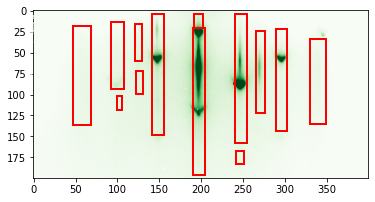

In [8]:
stripe_c = "crop_mask_stripe"
spot_c = "crop_mask_spot"

stripe_label = rle_decode(one[stripe_c], rd.pattern.shape) if not pd.isna(one[stripe_c]) else None
spot_label = rle_decode(one[spot_c], rd.pattern.shape) if not pd.isna(one[spot_c]) else None

rdm_stripe = RheedMask(rd, stripe_label)
rdm_spot = RheedMask(rd, spot_label)

rdm_stripe.get_regions()
rdm_stripe.plot_regions()

In [9]:
rdm_stripe.get_regions_collapse()
rdm_stripe.clean_collapse()
rdm_stripe.fit_collapse_peaks(height=0.001, threshold=0.000, prominence=0.001)
rdm_stripe.analyze_peaks_distance_cent(tolerant=0.1, abs_tolerant=4, allow_discontinue=1)

/home/aurora/rhana/rhana/pattern.py:440: UserWarning: Encounter LinAlgError when doing background removal! Singular matrix
  warnings.warn(f"Encounter LinAlgError when doing background removal! {e}")


[PeakAnalysisResult(peaks_family=array([ 1,  2,  5,  6,  7,  8,  9, 11]), avg_dist=49.166666666666664, avg_err=0.6666666666666666, detail=None),
 PeakAnalysisResult(peaks_family=array([ 3,  4,  6,  7, 10, 12]), avg_dist=72.125, avg_err=0.4375, detail=None),
 PeakAnalysisResult(peaks_family=array([0, 6, 7]), avg_dist=139.0, avg_err=0.0, detail=None)]

In [10]:
rdm_stripe.plot_peak_dist??

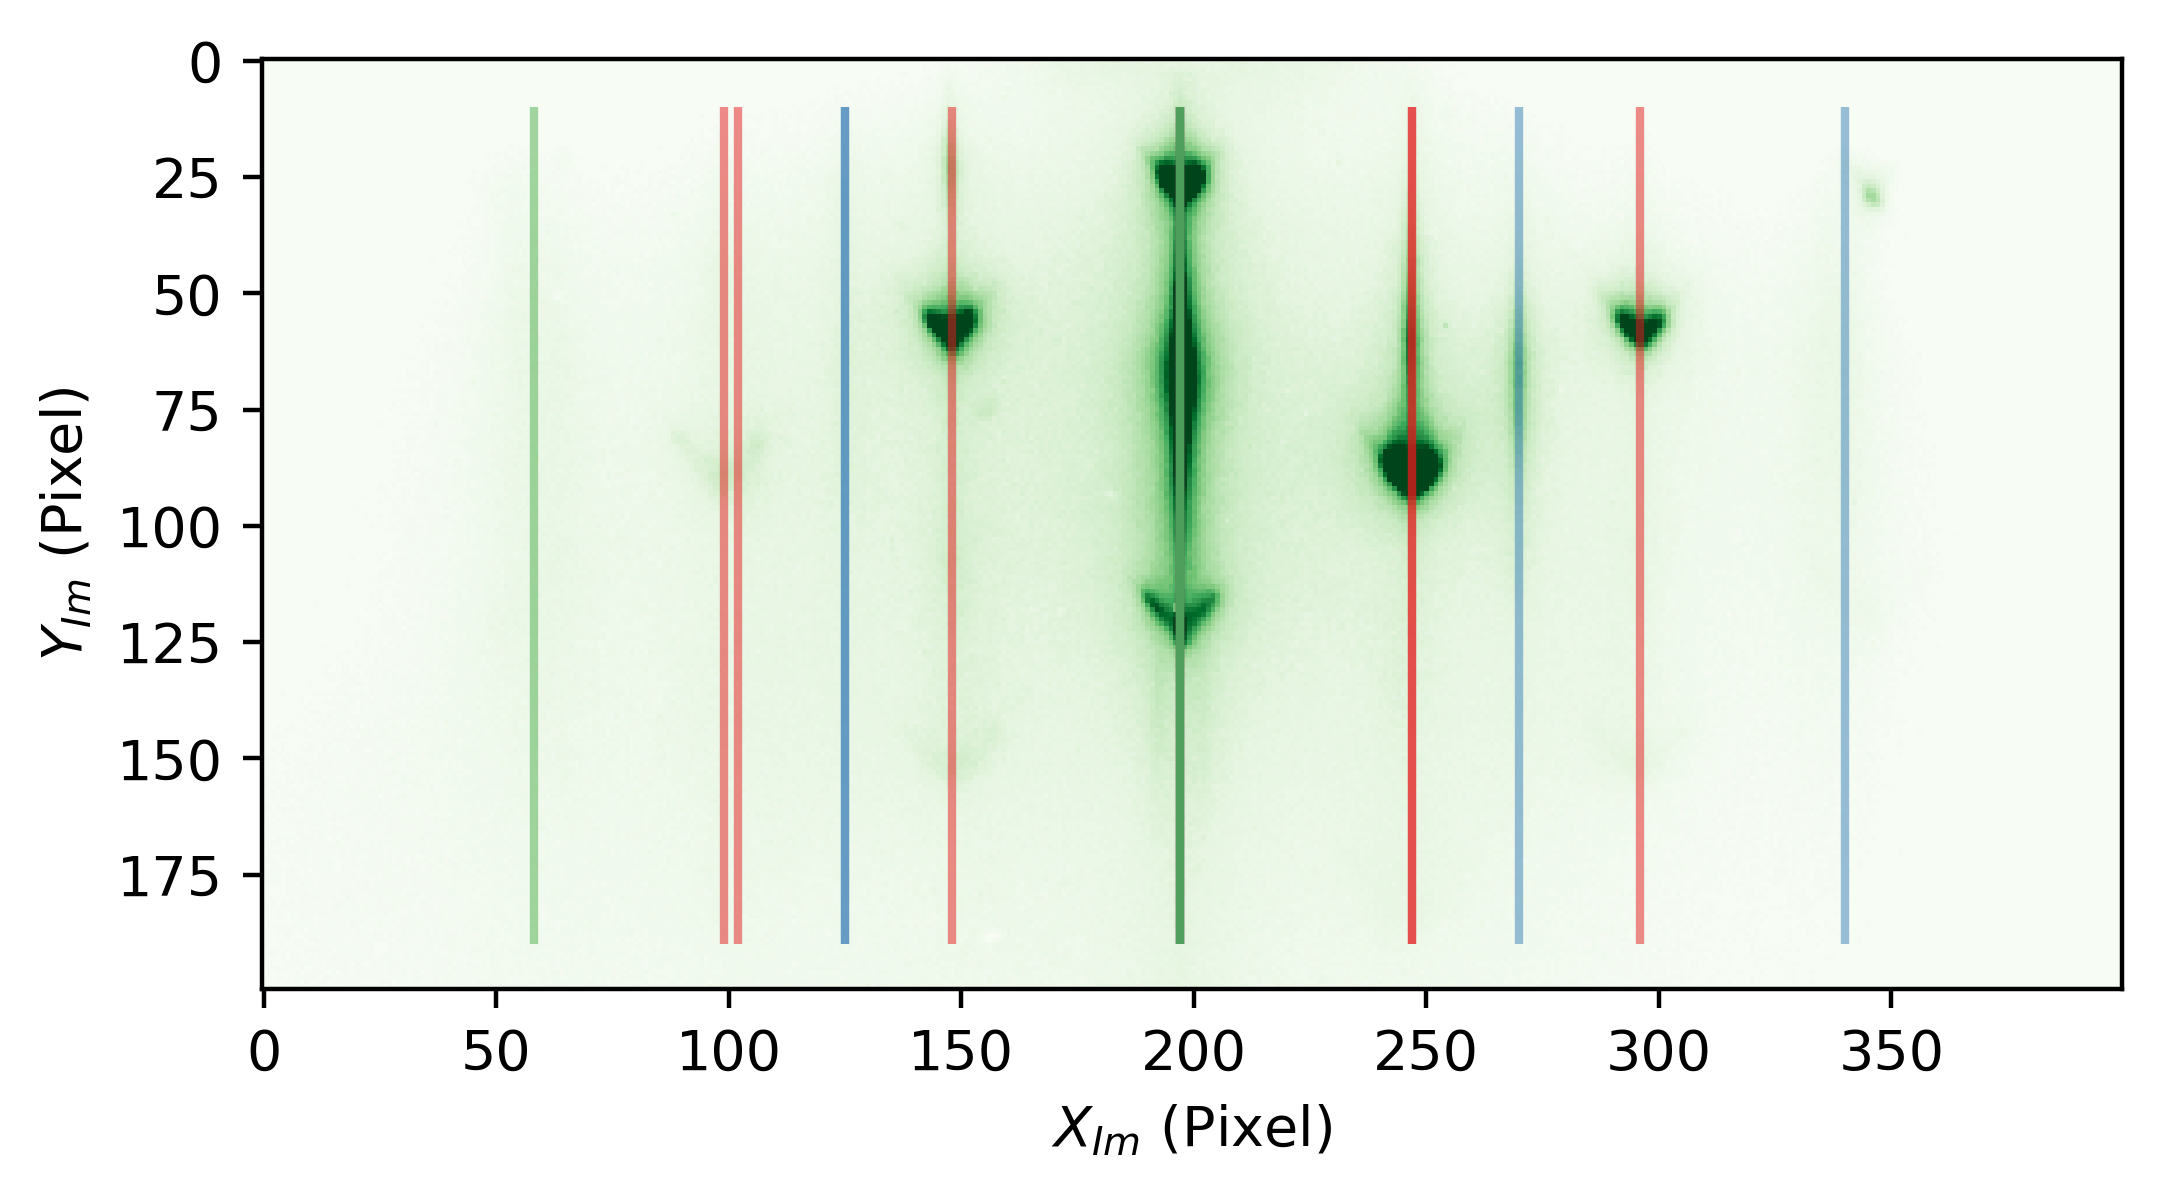

In [10]:
fig, ax = plt.subplots(dpi=400)
rdm_stripe.plot_peak_dist(ax=ax, dist_text_color=None, show_text=False)
ax.set_xlabel("$X_{Im}$ (Pixel)")
ax.set_ylabel("$Y_{Im}$ (Pixel)")
fig.savefig("publication/peak_distance.png", bbox_inches="tight")
